In [1061]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

## Single step process flow

This is a single step model for patient flow through a system. It has the following processes:
1. Update service time passing _(relevant for periods after first period)_
2. Move patients out of service to next step and free up servers _(relevant for periods after first period)_
3. Take new arrivals into system
4. Check number of free servers
5. Decide how many patients to move into service from wait list and from new arrivals, based on number of free servers
6. Assign patients to free servers, from wait list and/or new arrivals
7. Update wait time passing
8. Add new arrivals not assigned to free servers to waiting queue

## Functions

Functions for each process within a step

In [1062]:
def generate_service_time_type_condition(data, n_new_service_times = 1, skew = 0.05, n_samples = 1000) :
    """Get randomized service time based on type of condition"""
    # Choose random service time, with probabilities given by frequency
    condition_type = np.random.choice(data['Type'], p = data['Frequency']) 
    # Average service time for condition
    avg = data.loc[data['Type'] == condition_type, 'Time_Mean'].item() 
    # Worst case upper limit for condition
    worstcase = data.loc[data['Type'] == condition_type, 'Time_WorstCase'].item() 
    # % of time worst case for condition
    perc_worst_case = data.loc[data['Type'] == condition_type, 'Perc_WorstCase'].item() 
    # St Dev based on % of time worst case occurs
    std = worstcase / stats.skewnorm.ppf(1 - perc_worst_case, avg) 
    # Create distribution of 1000 samples based on condition type parameters
    dist = stats.skewnorm.rvs(skew, loc = avg, scale = std, size = n_samples)
    # Remove negative / too low results
    dist[dist < avg / 2] = avg / 2 
    # Return number of new service times needed (will always be 1 unless exceptional circumstances)
    serve_times = np.random.choice(dist, n_new_service_times) 
    # Round service times to nearest minute
    for i, s in enumerate(serve_times) :
        serve_times[i] = round(s)
    return condition_type, serve_times[0]

In [1063]:
def mark_service_time(dictionary_service, count_of_completed_service, service_time_tracker_dict, list_service_times_completed) :
    """Reduce the service time left for each patient to complete step by 1
    If service time  reduced to zero, remove patient from  dictionary, move to service completed, free up server
    Return modified service time dictionary
    In parallel, track service times that have been completed to generate avg service time estimate post-simulation"""
    # Reduce service time left to complete step
    for k, v in dictionary_service.items() :
        if np.isnan(v) :
            continue
        else :
            dictionary_service[k] -= 1
            # Count patient as completed step and free up server if service time is 0 
            if dictionary_service[k] == 0 :
                count_of_completed_service += 1
                dictionary_service[k] = np.nan
    # For patients who are marked as completed, track the actual service time completion for noting after simulation
    keys_for_removal = list()
    for k in service_time_tracker_dict.keys() :
        service_time_tracker_dict[k][0] += 1
        if service_time_tracker_dict[k][0] == service_time_tracker_dict[k][1] :
            list_service_times_completed.append(service_time_tracker_dict[k][1])
            keys_for_removal.append(k)
    for k in keys_for_removal :
        del service_time_tracker_dict[k]
    return dictionary_service, count_of_completed_service, list_service_times_completed

In [1064]:
def check_servers_free(dictionary_service) :
    """Verify if servers are free (denoted by np.nan as value for server key)
    And, if free servers exist, how many"""
    count_servers_free = 0
    for k, v in dictionary_service.items() :
        if np.isnan(v) :
            count_servers_free += 1
    return count_servers_free

In [1065]:
def how_many_to_move_from_where(dictionary_waiting, count_servers_free, count_n_arrivals) :
    """Determine how many people to move from wait list to service / from new arrivals to service"""
    count_from_wait_list = min(len(dictionary_waiting.keys()), count_servers_free)
    count_servers_free = count_servers_free - count_from_wait_list
    count_from_new_arrivals = min(count_n_arrivals, count_servers_free)
    return count_from_wait_list, count_from_new_arrivals

In [1066]:
def move_from_wait_list_to_service(dictionary_waiting, dictionary_service, count_from_wait_list, list_waiting_time, service_time_tracker_dict) :
    """Move patients from wait list to free servers
    To be preceded by: if count_from_wait_list > 0"""
    patients_on_wait_list = np.sort(list(dictionary_waiting.keys()))
    patients_move_to_serve = patients_on_wait_list[:count_from_wait_list]
    for m in patients_move_to_serve :
        list_waiting_time.append(dictionary_waiting[m])
        del dictionary_waiting[m]
        for k, v in dictionary_service.items() :
            if np.isnan(v) :
                condition, serve_time = generate_service_time_type_condition(base_case_types)
                dictionary_service[k] = serve_time
                unique_key = 'Service_' + str(serve_time) + '_' + str(p) ###
                service_time_tracker_dict[unique_key] = [0, serve_time] ###
    return dictionary_waiting, dictionary_service, list_waiting_time, service_time_tracker_dict

In [1067]:
def move_from_arrival_to_service(dictionary_service, count_n_arrivals, count_from_new_arrivals, service_time_tracker_dict) :
    """Move patients from arrivals to free servers
    To be preceded by: if count_from_new_arrivals > 0 """
    count_arrivals_placed = 0
    for k, v in dictionary_service.items() :
        if np.isnan(v) :
            condition, serve_time = generate_service_time_type_condition(base_case_types)
            dictionary_service[k] = serve_time
            unique_key = 'Service_' + str(serve_time) + '_' + str(p) ###
            service_time_tracker_dict[unique_key] = [0, serve_time] ###
            count_arrivals_placed += 1
            if count_arrivals_placed >= count_from_new_arrivals :
                break
    return dictionary_service, count_arrivals_placed, service_time_tracker_dict

In [1068]:
def add_to_wait_list(dictionary_waiting, count_n_arrivals, count_arrivals_placed) :
    """Move patients from arrivals to wait list
    To be preceded by: if arrivals_placed < n_arrivals"""
    count_diff = count_n_arrivals - count_arrivals_placed
    wait_keys = np.sort(list(dictionary_waiting.keys()))
    for i in range(count_diff) :
        if len(wait_keys) < 1 :
            new_waitname = 'Waiting' + str(i)
            dictionary_waiting[new_waitname] = 1
        else :
            count_lastwaiter = int(wait_keys[-1][7:])
            new_waitname = 'Waiting' + str(count_lastwaiter + i + 1)
            dictionary_waiting[new_waitname] = 1
    return dictionary_waiting

## Looped model

### _Function to generate step tracking objects_

In [1069]:
def generate_step_objects(n_servers, n_periods) :
    # Treat servers as dictionary to keep track of who is busy
    # NaN means empty server
    # If busy, dict will take form of {'Server#': n_minutes_left_service}
    dictionary_servers = {}
    for i in range(n_servers) :
        servname = 'Server' + str(i)
        dictionary_servers[servname] = np.nan
    # Treat waiting as dictionary
    # If someone waits, will be added to dictionary with form of {'Waiting#': n_minutes_waiting}
    dictionary_waiting = {}
    # Temporary tracker dictionary for service times
    dictionary_track_serve_time = {}
    # Holding lists for completed service times and completed waiting times (for measurement post-simulation)
    list_waiting_times = list()
    list_service_completed_times = list()
    # Set counter for completed service to 0
    count_service_completed = 0
    # Array for holding onto step-by-step process
    # Shape: number_of_periods x 4 -> [n_arrivals, n_being_served, n_waiting, n_completed]
    tracker = np.zeros(shape = (n_periods, 4))
    return dictionary_servers, dictionary_waiting, dictionary_track_serve_time, list_waiting_times,\
list_service_completed_times, count_service_completed, tracker

### _Parameters and initial objects_

#### _Parameters data_

In [1070]:
# Estimates for how often the worst case scenario in patient service times occurs
low = 0.05
medium = 0.1
high = 0.2

In [1071]:
# Data table for drawing service times for patients
cols = ['Type', 'Frequency', 'Time_Mean', 'Time_WorstCase', 'Perc_WorstCase']
preventative = ['Preventative', 0.2, 30, 30, low]
chronic = ['Chronic', 0.6, 30, 30, medium]
acute = ['Acute', 0.2, 15, 5, low]
base_case_types = pd.DataFrame([preventative, chronic, acute], columns = cols)
base_case_types

,Type,Frequency,Time_Mean,Time_WorstCase,Perc_WorstCase
0,Preventative,0.2,30,30,0.05
1,Chronic,0.6,30,30,0.10
2,Acute,0.2,15,5,0.05


In [1072]:
# Arrivals to be modeled as poisson, scaling down to minute arrivals
arrivals_day = 100
arrivals_hour = arrivals_day / 10
arrivals_minute = arrivals_hour / 60

In [1073]:
n_servers = 9 # Static sample number of servers

In [1074]:
# 1 hour as 60 periods of 1 minute
hours = 9
n_periods = 60 * hours

#### _Initialize objects_

In [1075]:
server_dict, waiting_dict, serve_time_track_dict,\
waiting_time_list, service_times_completed_list, service_completed, tracker\
= generate_step_objects(n_servers, n_periods)

### _Running model_

In [1076]:
for p in range(n_periods) :
    server_dict, service_completed, service_times_completed_list = mark_service_time(server_dict, service_completed, serve_time_track_dict, service_times_completed_list)
    n_arrivals = np.random.poisson(arrivals_minute)
    n_servers_free = check_servers_free(server_dict)
    from_wait_list, from_new_arrivals = how_many_to_move_from_where(waiting_dict, n_servers_free, n_arrivals)
    if from_wait_list > 0 :
        waiting_dict, server_dict, waiting_time_list, serve_time_track_dict = move_from_wait_list_to_service(waiting_dict, server_dict, from_wait_list, waiting_time_list, serve_time_track_dict)
    if from_new_arrivals > 0 :
        server_dict, n_arrivals_placed, serve_time_track_dict = move_from_arrival_to_service(server_dict, n_arrivals, from_new_arrivals, serve_time_track_dict)
    else :
        n_arrivals_placed = 0
    waiting_dict = {k:v + 1 for k, v in waiting_dict.items()}
    waiting_dict = add_to_wait_list(waiting_dict, n_arrivals, n_arrivals_placed)
    
    tracker[p] = [n_arrivals, n_servers - [v for v in server_dict.values()].count(np.nan), len(waiting_dict.keys()), service_completed]
    
    ## ===== Comment out below to get period-by-period summaries of system =====
    
#     print ('\n======\n======\n\nAfter t_{}'.format(p))
#     print ('Arrivals:', n_arrivals)
#     print ('{} moved from wait list to service'.format(from_wait_list))
#     print ('{} moved from arrivals to service'.format(from_new_arrivals))
#     print ('{} completed service'.format(service_completed))
#     print ('Service queue', server_dict)
#     print ('Waiting queue', waiting_dict)

## Visualizing flow

In [1077]:
periods = np.arange(0, n_periods)
arrivals = tracker[:, 0]
serving = tracker[:, 1]
waiting = tracker[:, 2]
served = tracker[:, 3]

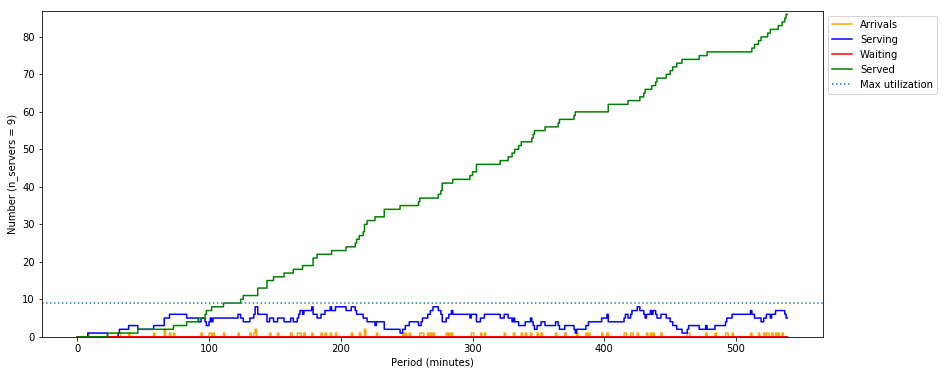

In [1078]:
fig, ax1 = plt.subplots(figsize = (14, 6))

ax1.step(periods, arrivals, c = 'orange', label = 'Arrivals')
ax1.step(periods, serving, c = 'blue', label = 'Serving')
ax1.step(periods, waiting, c = 'red', label = 'Waiting')
ax1.step(periods, served, c = 'green', label = 'Served')

ax1.axhline(n_servers, ls = ':', label = 'Max utilization')

ax1.set_ylim(0, np.max(tracker) + 1)
ax1.set_xlabel('Period (minutes)')
ax1.set_ylabel('Number (n_servers = {})'.format(n_servers))

plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [1079]:
print ('Total arrived: {}'.format(np.sum(arrivals)))
print ('Total served: {}'.format(np.max(served)))
print ('Mean service time: {:.2f}'.format(np.mean(service_times_completed_list)))
print ('Mean n_patients waiting: {:.2f}'.format(np.mean(waiting)))
print ('Mean waiting time: {:.2f}'.format(np.sum(waiting_time_list) / np.max(served)))
print ('Mean time in system: {:.2f}'.format((np.sum(waiting_time_list) / np.max(served)) + np.mean(service_times_completed_list)))
print ('Mean waiting time for those who waited: {:.2f}'.format(np.mean(waiting_time_list)))

Total arrived: 91.0
Total served: 86.0
Mean service time: 27.06
Mean n_patients waiting: 0.00
Mean waiting time: 0.00
Mean time in system: 27.06
Mean waiting time for those who waited: nan


In [1080]:
# Clear variables to re-run
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
